Text(0.5, 0, 'Days')

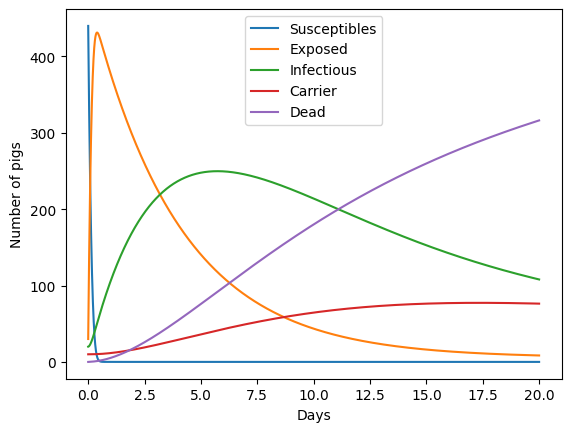

In [ ]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import numpy as np

def RK4sys(f,y_0,t_0,t_f,N):

    h = (t_f - t_0) / N
    t = np.linspace(t_0,t_f,N+1)
    f_ = lambda t, y : np.asarray(f(t,y))
    y = np.zeros((N+1,len(y_0)))
    y[0]=y_0
    
    ## RK4
    for n in range(0,N):
        k1 = f_(t[n],y[n])
        k2 = f_(t[n] + 0.5 * h,y[n] + h * 0.5 * k1)
        k3 = f_(t[n] + 0.5 * h,y[n] + h * 0.5 * k2)
        k4 = f_(t[n] + h, y[n] + h * k3)
        y[n+1] = y[n] + h * ((1.0 / 6.0) * k1 + (1.0 / 3.0) * k2 + (1.0 / 3.0) * k3 + (1.0 / 6.0) * k4)

    return h, y, t

t_0=0.0
t_f=20.0
N=2**16

Y_0 = [440,30,20,10,0]
Y_0 = Y_0 / 500.0
mu = 0.0027
beta = 0.3
gamma = 0.125
p = 0.7
sigma = 0.25
kappa = 0.06
eps = 0.3

#Implementing the model
def f(t,y):
    y1,y2,y3,y4,y5 = y
    sum = y1+y2+y3+y4+y5
    return [-beta * y1 * (y3 + eps * y4) + mu * sum - mu * y1,
            beta * y1 *(y3 + eps * y4) - (sigma + mu) * y2,
            sigma * y2 + kappa * y4 - gamma *p* y3 - gamma * (1-p) * y3  - mu * y3,
            gamma * (1-p) * y3 - (kappa + mu) * y4,
            gamma * p * y3]


h, y, t_n = RK4sys(f, Y_0, t_0, t_f, N)

first = y[:,0]
second =  y[:,1]
third = y[:,2]
fourth = y[:,3]
fifth = y[:,4]

plt.plot(t_n,first,t_n,second, t_n, third, t_n, fourth, t_n, fifth)
plt.legend(['Susceptibles', 'Exposed', 'Infectious', 'Carrier', 'Dead'])
plt.ylabel("Number of pigs")
plt.xlabel("Days")



cpu
checkpoint directory created: ./model
saving model version 0.0


ODE loss: 1.91e+02 | IC loss: 9.13e+01 | total: 1.10e+02: 100%|█████| 40/40 [05:30<00:00,  8.27s/it]


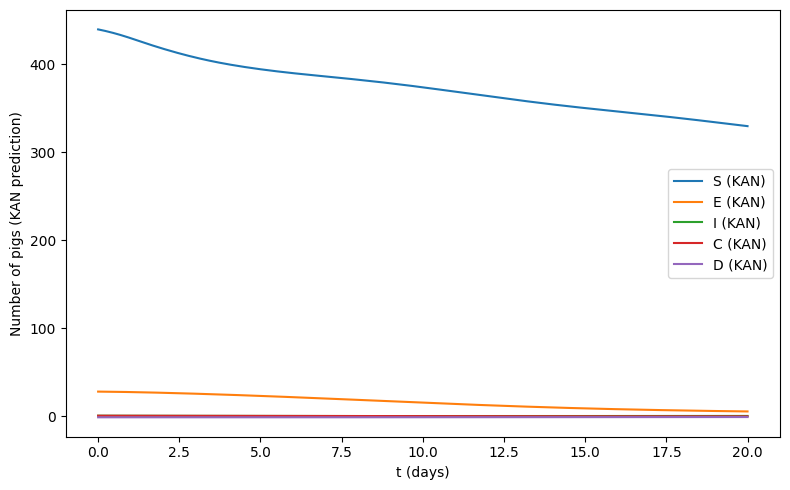

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

N=512

Y_0_KAN = torch.tensor(Y_0, dtype=torch.float32, device=device).unsqueeze(0)  # shape (1,5)

#timesteps
t_c = torch.linspace(t_0, t_f, N, dtype=torch.float32).unsqueeze(1).to(device)  # shape (N, 1)

#Initial conddition
t_ic = torch.tensor([[t_0]], dtype=torch.float32, device=device)  # shape (1,1)

t_min, t_max = t_0, t_f
def scale_t(t):
    return (t - t_min) / (t_max - t_min)

def unscale_t(t_scaled):
    return t_scaled * (t_max - t_min) + t_min

#t_c = scale_t(t_c)
#t_ic = scale_t(t_ic)

def batch_jacobian(func, x, create_graph=False):
    
    def _func_sum(x):
        return func(x).sum(dim=0)   # (m,)
    J = autograd.functional.jacobian(_func_sum, x, create_graph=create_graph)
    # J shape: (m, B, d) -> permute to (B, m, d)
    return J.permute(1, 0, 2)

def dy_dt_model(model, t):
    t = t.clone().detach().requires_grad_(True)
    y = model(t)
    B, m = y.shape

    grads = []
    for i in range(m):
        g = torch.autograd.grad(
            y[:, i].sum(), t, create_graph=True
        )[0]
        grads.append(g)

    dy_dt = torch.cat(grads, dim=1)
    return dy_dt, y


def ode_rhs_for_batch(t, y):
    """
    RHS for tensors
    """
    S = y[:, 0:1]
    E = y[:, 1:2]
    I = y[:, 2:3]
    C = y[:, 3:4]
    D = y[:, 4:5]

    y_arr = [S,E,I,C,D]

    return torch.cat(f(t,y_arr), dim=1)

model = KAN(width=[1,8,8, 5], grid=20, k=3, seed=1, device=device)

steps = 40
alpha = 0.1
log_every = 1

def train():
    #, tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe")

    pbar = tqdm(range(steps), desc="Training KAN ODE solver", ncols=100)

    for it in pbar:
        def closure():
            optimizer.zero_grad()

            # ODE residual on collocation points
            y_pred = model(t_c)#Evaluate model
            dy_dt  = batch_jacobian(model, t_c, True)#shape (N, 5, 1)
            #dy_dt, y_pred = dy_dt_model(model, t_c)
            dy_dt  = dy_dt[:, :, 0] #Correct shape (N, 5), derivative wrt time
    
            rhs = ode_rhs_for_batch(t_c, y_pred)#True derivative based on the problem
            ode_loss = torch.mean((dy_dt - rhs) ** 2)#ODE loss calculation

            # Initial condition loss at t = 0
            y_ic_pred = model(t_ic)#shape (1,5)
            ic_loss   = torch.mean((y_ic_pred - Y_0_KAN) ** 2)#calculate Initial condition loss

            loss = alpha * ode_loss + ic_loss#weighted loss
            loss.backward()

            # Store for logging outside the closure
            closure.ode_loss = ode_loss.detach()
            closure.ic_loss = ic_loss.detach()
            closure.loss = loss.detach()

            return loss

        # Optional: adapt KAN grid every few iterations
        if it % 5 == 0:
            model.update_grid_from_samples(t_c)

        optimizer.step(closure)

        if it % log_every == 0:
            ode_l = closure.ode_loss.item()
            ic_l  = closure.ic_loss.item()
            total = closure.loss.item()
            pbar.set_description(
                f"ODE loss: {ode_l:.2e} | IC loss: {ic_l:.2e} | total: {total:.2e}"
            )

# Run training
train()

#evaluate, plot
with torch.no_grad():
    t_eval = torch.linspace(t_0, t_f, 1000).unsqueeze(1).to(device)
    t_eval = scale_t(t_eval)
    y_eval = model(t_eval).cpu().numpy()

t_eval_np = unscale_t(t_eval).cpu().numpy().flatten()

plt.figure(figsize=(8,5))
plt.plot(t_eval_np, y_eval[:,0], label="S (KAN)")
plt.plot(t_eval_np, y_eval[:,1], label="E (KAN)")
plt.plot(t_eval_np, y_eval[:,2], label="I (KAN)")
plt.plot(t_eval_np, y_eval[:,3], label="C (KAN)")
plt.plot(t_eval_np, y_eval[:,4], label="D (KAN)")
plt.xlabel("t (days)")
plt.ylabel("Number of pigs (KAN prediction)")
plt.legend()
plt.tight_layout()
plt.show()




saving model version 0.2


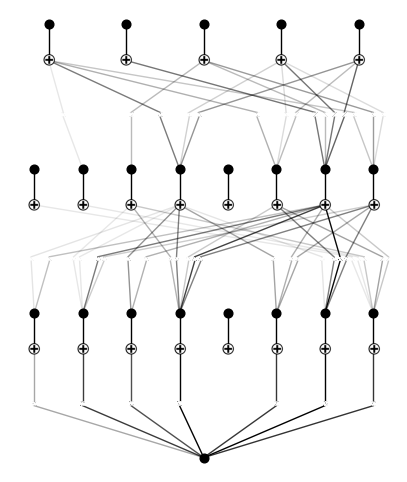

In [50]:

model = model.prune()
model.plot()

Using device: cpu
checkpoint directory created: ./model
saving model version 0.0
    0: ODE loss = 1.787e-01, IC loss = 3.900e+04, total = 3.900e+04
  100: ODE loss = 1.567e-01, IC loss = 3.886e+04, total = 3.886e+04
  200: ODE loss = 6.078e-02, IC loss = 3.850e+04, total = 3.850e+04
  300: ODE loss = 1.507e+00, IC loss = 3.769e+04, total = 3.769e+04
  400: ODE loss = 1.196e+01, IC loss = 3.657e+04, total = 3.658e+04
  500: ODE loss = 2.874e+01, IC loss = 3.516e+04, total = 3.519e+04
  600: ODE loss = 4.172e+01, IC loss = 3.349e+04, total = 3.354e+04
  700: ODE loss = 3.660e+01, IC loss = 3.153e+04, total = 3.157e+04
  800: ODE loss = 3.237e+01, IC loss = 2.929e+04, total = 2.932e+04
  900: ODE loss = 3.321e+01, IC loss = 2.681e+04, total = 2.684e+04
 1000: ODE loss = 3.074e+01, IC loss = 2.412e+04, total = 2.415e+04
 1100: ODE loss = 2.686e+01, IC loss = 2.130e+04, total = 2.133e+04
 1200: ODE loss = 2.314e+01, IC loss = 1.840e+04, total = 1.843e+04
 1300: ODE loss = 1.977e+01, IC los

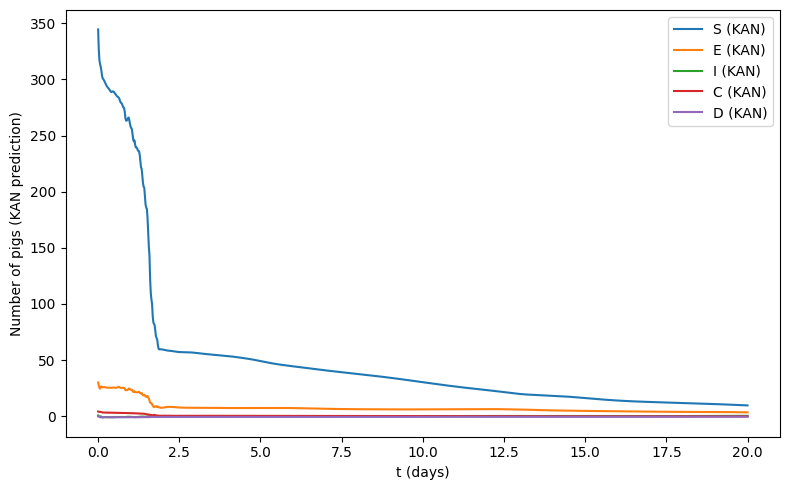

In [39]:
import torch
from torch import autograd
import matplotlib.pyplot as plt
from kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -------------------------------------------------------
# 1. Parameters of the SEICD model
# -------------------------------------------------------



# Time interval
t_0 = 0.0
t_f = 20.0    

# -------------------------------------------------------
# 2. Turn initial condition into a tensor
# -------------------------------------------------------
Y_0_KAN = torch.tensor(Y_0, dtype=torch.float32, device=device).unsqueeze(0)  # (1,5)

# Collocation points for ODE residual
N = 256
t_c = torch.linspace(t_0, t_f, N, dtype=torch.float32, device=device).unsqueeze(1)  # (N,1)

# Initial condition time
t_ic = torch.tensor([[t_0]], dtype=torch.float32, device=device)  # (1,1)


# -------------------------------------------------------
# 3. The ODE RHS (your original f, used in batched form)
# -------------------------------------------------------
def f(t, y):
    """
    y is a list [y1, y2, y3, y4, y5]
    Each yk can be a scalar or a tensor of shape (N,1).
    """
    y1, y2, y3, y4, y5 = y
    s = y1 + y2 + y3 + y4 + y5

    dy1 = -beta * y1 * (y3 + eps * y4) + mu * s - mu * y1
    dy2 =  beta * y1 * (y3 + eps * y4) - (sigma + mu) * y2
    dy3 =  sigma * y2 + kappa * y4 - gamma * p * y3 - gamma * (1 - p) * y3 - mu * y3
    dy4 =  gamma * (1 - p) * y3 - (kappa + mu) * y4
    dy5 =  gamma * p * y3

    return [dy1, dy2, dy3, dy4, dy5]


def ode_rhs_for_batch(t, y):
    """
    t: (N,1) tensor (not actually used in this RHS, but kept for generality)
    y: (N,5) tensor of model outputs [S,E,I,C,D]
    returns: (N,5) tensor of RHS values
    """
    S = y[:, 0:1]
    E = y[:, 1:2]
    I = y[:, 2:3]
    C = y[:, 3:4]
    D = y[:, 4:5]

    y_arr = [S, E, I, C, D]
    rhs_list = f(t, y_arr)  # list of 5 tensors, each (N,1)

    return torch.cat(rhs_list, dim=1)  # (N,5)


# -------------------------------------------------------
# 4. Derivative of model output wrt time
# -------------------------------------------------------
def dy_dt_model(model, t):
    """
    model: KAN mapping R^1 -> R^5
    t: (N,1) tensor
    returns:
        dy_dt: (N,5) time derivative of model output
        y:     (N,5) model output at t
    """
    t = t.clone().detach().requires_grad_(True)  # we need grad wrt t
    y = model(t)  # (N,5)

    B, m = y.shape
    grads = []

    # Compute ∂y_i/∂t for each component i
    for i in range(m):
        g = torch.autograd.grad(
            y[:, i].sum(),  # scalar
            t,
            create_graph=True
        )[0]              # (N,1)
        grads.append(g)

    dy_dt = torch.cat(grads, dim=1)  # (N,5)
    return dy_dt, y


# -------------------------------------------------------
# 5. Define the KAN model
# -------------------------------------------------------
model = KAN(width=[1, 8, 5, 5], grid=5, k=3, seed=1, device=device)

# -------------------------------------------------------
# 6. Training with Adam
# -------------------------------------------------------
steps = 2000          # you can increase if needed
log_every = 100       # print every 100 steps

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for it in range(steps):
    optimizer.zero_grad()

    # ODE residual
    dy_dt, y_pred = dy_dt_model(model, t_c)   # (N,5), (N,5)
    rhs = ode_rhs_for_batch(t_c, y_pred)      # (N,5)
    ode_loss = torch.mean((dy_dt - rhs) ** 2)

    # Initial condition at t = t_0
    y_ic_pred = model(t_ic)                   # (1,5)
    ic_loss   = torch.mean((y_ic_pred - Y_0_KAN) ** 2)

    loss = ode_loss + ic_loss
    loss.backward()
    optimizer.step()

    if it % log_every == 0:
        print(f"{it:5d}: ODE loss = {ode_loss.item():.3e}, "
              f"IC loss = {ic_loss.item():.3e}, total = {loss.item():.3e}")

# -------------------------------------------------------
# 7. Evaluation & plotting
# -------------------------------------------------------
with torch.no_grad():
    t_eval = torch.linspace(t_0, t_f, 1000, device=device).unsqueeze(1)
    y_eval = model(t_eval).cpu().numpy()

t_eval_np = t_eval.cpu().numpy().flatten()

plt.figure(figsize=(8, 5))
plt.plot(t_eval_np, y_eval[:, 0], label="S (KAN)")
plt.plot(t_eval_np, y_eval[:, 1], label="E (KAN)")
plt.plot(t_eval_np, y_eval[:, 2], label="I (KAN)")
plt.plot(t_eval_np, y_eval[:, 3], label="C (KAN)")
plt.plot(t_eval_np, y_eval[:, 4], label="D (KAN)")
plt.xlabel("t (days)")
plt.ylabel("Number of pigs (KAN prediction)")
plt.legend()
plt.tight_layout()
plt.show()
